In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['VLLM_USE_V1'] = '0'
os.environ["NVTE_ALLOW_NONDETERMINISTIC_ALGO"] = "1"

import torch
import vllm
from vllm import LLM, SamplingParams
from vllm.model_executor import SamplingMetadata
from vllm.model_executor.layers.logits_processor import _prune_hidden_states
from transformers import AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm


import inference_verification.data_utils as data_utils

/workspace/inference_verification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 06-12 21:29:06 [__init__.py:239] Automatically detected platform cuda.


2025-06-12 21:29:07,873	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
model_name = "google/gemma-2-2b-it"
dtype = "bfloat16"
dataset_name = "lmsys/lmsys-chat-1m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
ctx_len = 512

max_decode_tokens = 0
n_samples = 100

sampling_params = SamplingParams(temperature=0.8, top_p=0.95, ignore_eos=True, max_tokens=max_decode_tokens + 1)
sampling_params = SamplingParams(temperature=0.0, ignore_eos=True, max_tokens=max_decode_tokens+1)

In [5]:

ds = load_dataset(dataset_name, split="train")
prompts = [i['conversation'] for _, i in zip(range(n_samples), ds)]

prompts = [tokenizer.apply_chat_template(prompt, tokenize=False) for prompt in prompts]

tokenized_inputs = tokenizer(prompts, padding=False, return_tensors=None, add_special_tokens=False, truncation=True, max_length=ctx_len)
prompt_token_ids = [input_ids for input_ids in tokenized_inputs["input_ids"]]

for i in range(len(prompt_token_ids)):
    print(len(prompt_token_ids[i]))



print(prompts[0])

259
1024
359
165
210
220
320
388
701
704
<bos><start_of_turn>user
how can identity protection services help protect me against identity theft<end_of_turn>
<start_of_turn>model
Identity protection services can help protect you against identity theft in several ways:

1. Monitoring: Many identity protection services monitor your credit reports, public records, and other sources for signs of identity theft. If they detect any suspicious activity, they will alert you so you can take action.
2. Credit freeze: Some identity protection services can help you freeze your credit, which makes it more difficult for thieves to open new accounts in your name.
3. Identity theft insurance: Some identity protection services offer insurance that can help you recover financially if you become a victim of identity theft.
4. Assistance: Many identity protection services offer assistance if you become a victim of identity theft. They can help you file a police report, contact credit bureaus, and other steps

In [ ]:
# llm_8bit = LLM(
#     model=model_name,
#     tensor_parallel_size=1,
#     max_model_len=ctx_len*2,
#     enforce_eager=True,
#     dtype=dtype,
#     disable_async_output_proc=True,
#     quantization="fp8",
# )

llm = LLM(
    model=model_name,
    tensor_parallel_size=1,
    max_model_len=ctx_len*8,
    enforce_eager=True,
    dtype=dtype,
    disable_async_output_proc=True,
)
model = llm.llm_engine.model_executor.driver_worker.model_runner.model

INFO 06-12 21:29:26 [config.py:717] This model supports multiple tasks: {'generate', 'embed', 'score', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 06-12 21:29:26 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='google/gemma-2-2b-it', speculative_config=None, tokenizer='google/gemma-2-2b-it', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  2.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.96it/s]


INFO 06-12 21:29:29 [loader.py:458] Loading weights took 1.03 seconds
INFO 06-12 21:29:29 [model_runner.py:1140] Model loading took 4.9000 GiB and 1.381950 seconds


INFO 06-12 21:29:30 [worker.py:287] Memory profiling takes 1.18 seconds
INFO 06-12 21:29:30 [worker.py:287] the current vLLM instance can use total_gpu_memory (23.58GiB) x gpu_memory_utilization (0.90) = 21.23GiB
INFO 06-12 21:29:30 [worker.py:287] model weights take 4.90GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 2.34GiB; the rest of the memory reserved for KV Cache is 13.93GiB.
INFO 06-12 21:29:30 [executor_base.py:112] # cuda blocks: 8779, # CPU blocks: 2520
INFO 06-12 21:29:30 [executor_base.py:117] Maximum concurrency for 2048 tokens per request: 68.59x
INFO 06-12 21:29:34 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 5.11 seconds


In [84]:
activations_v1 = {}
temp_saved_activations = []
def activation_saving_hook(module, input, output):
    temp_saved_activations.append(output[0].detach().clone())



def toploc_cache_hook_prefill(_, inputs: tuple):
    """
    initial version from: https://github.com/PrimeIntellect-ai/prime-rl/blob/main/src/zeroband/inference/toploc.py#L155-L184
    Pre-hook to get final hidden states of a model forward pass and add it to
    the TOPLOC cache based on sampling metadata.


    Args:
        _ (): Unused argument, required for compatibility with hook function signature.
        input (tuple): A tuple containing the input data. The first element is expected to be the hidden states of the model, and the second element is expected to be the sampling metadata.
        toploc_cache (TopLocCache): The TopLocCache instance to which the processed data will be added.
    """
    hidden_states, sampling_metadata = inputs[1], inputs[2]
    assert isinstance(hidden_states, torch.Tensor)
    assert isinstance(sampling_metadata, SamplingMetadata)

    # This check is true only for prefills
    # if max(sampling_metadata.selected_token_indices) > len(sampling_metadata.seq_groups):
    #     return

    # This pruning is required when cuda graph padding is enabled.
    # print(hidden_states.shape)
    # hidden_states = _prune_hidden_states(hidden_states, sampling_metadata)
    # print(f"hidden_states.shape after pruning: {hidden_states.shape}")
    # if len(sampling_metadata.seq_groups) != hidden_states.shape[0]:
    #     raise ValueError(f"Lengths dont match: {len(sampling_metadata.seq_groups)} {hidden_states.shape}")

    cur_pos = 0

    for i in range(len(sampling_metadata.seq_groups)):
        seq_id = sampling_metadata.seq_groups[i].seq_ids[0]
        tokens = sampling_metadata.seq_groups[i].seq_data[seq_id].prompt_token_ids

        cur_activations = hidden_states[cur_pos:cur_pos+len(tokens)]
        cur_pos += len(tokens)

        assert len(cur_activations) == len(tokens), f"{len(cur_activations)} {len(tokens)} MISMATCH"

        activations_v1[tokens] = cur_activations
    

    # Add hidden states to TOPLOC cache with corresponding seq_ids
    # temp_saved_activations.append((hidden_states, seq_ids))

In [85]:
# saved_activations_handle = model.model.norm.register_forward_hook(activation_saving_hook)
logits_processor = llm.llm_engine.model_executor.driver_worker.model_runner.model.logits_processor

saved_activations_handle = logits_processor.register_forward_pre_hook(toploc_cache_hook_prefill)

activations_v1 = {}
orig_activations = []

prefill_tokens = []


sampling_params = SamplingParams(temperature=0.0, ignore_eos=True, max_tokens=max_decode_tokens+1)


try:
    outputs = llm.generate(prompt_token_ids=prompt_token_ids, sampling_params=sampling_params, use_tqdm=False)
    # orig_activations.append(temp_saved_activations)
    # temp_saved_activations = []
    # # print(outputs)
    # # print(torch.tensor(outputs[0].outputs[0].token_ids).shape)
    # prefill_tokens.append(prompt_token_ids[i] + list(outputs[0].outputs[0].token_ids))
except Exception as e:
    print(e)
finally:
    saved_activations_handle.remove()



In [86]:
print(len(activations_v1.keys()))

10


In [90]:
saved_activations_handle = model.model.norm.register_forward_hook(activation_saving_hook)
# logits_processor = llm.llm_engine.model_executor.driver_worker.model_runner.model.logits_processor


# saved_activations_handle = logits_processor.register_forward_pre_hook(toploc_cache_hook_prefill)

temp_saved_activations = []
orig_activations = []

prefill_tokens = []

activations_v2 = {}

sampling_params = SamplingParams(temperature=0.0, ignore_eos=True, max_tokens=max_decode_tokens+1)


try:
    for i in range(len(prompt_token_ids)):
        outputs = llm.generate(prompt_token_ids=prompt_token_ids[i], sampling_params=sampling_params, use_tqdm=False)
        activations_v2[tuple(prompt_token_ids[i])] = temp_saved_activations[0]
        temp_saved_activations = []
        # # print(outputs)
        # # print(torch.tensor(outputs[0].outputs[0].token_ids).shape)
    # prefill_tokens.append(prompt_token_ids[i] + list(outputs[0].outputs[0].token_ids))
except Exception as e:
    print(e)
finally:
    saved_activations_handle.remove()

# try:
#     for i in tqdm(range(len(prompt_token_ids)), desc="Generating activations"):
#         outputs = llm.generate(prompt_token_ids=prompt_token_ids[i], sampling_params=sampling_params, use_tqdm=False)
#         orig_activations.append(temp_saved_activations)
#         temp_saved_activations = []
#         # print(outputs)
#         # print(torch.tensor(outputs[0].outputs[0].token_ids).shape)
#         prefill_tokens.append(prompt_token_ids[i] + list(outputs[0].outputs[0].token_ids))
# except Exception as e:
#     print(e)
# finally:
#     saved_activations_handle.remove()


In [92]:
print(list(activations_v1.keys())[0])
print(list(activations_v2.keys())[0])

(2, 106, 1645, 108, 1139, 798, 12852, 6919, 3545, 1707, 9051, 682, 2691, 12852, 37214, 107, 108, 106, 2516, 108, 22869, 6919, 3545, 798, 1707, 9051, 692, 2691, 12852, 37214, 575, 3757, 5742, 235292, 109, 235274, 235265, 29654, 235292, 9429, 12852, 6919, 3545, 8200, 861, 6927, 8134, 235269, 2294, 9126, 235269, 578, 1156, 8269, 604, 11704, 576, 12852, 37214, 235265, 1927, 984, 21422, 1089, 45637, 5640, 235269, 984, 877, 14838, 692, 712, 692, 798, 1987, 3105, 235265, 108, 235284, 235265, 14882, 35059, 235292, 4213, 12852, 6919, 3545, 798, 1707, 692, 35059, 861, 6927, 235269, 948, 3833, 665, 978, 5988, 604, 72731, 577, 2174, 888, 12210, 575, 861, 1503, 235265, 108, 235304, 235265, 39310, 37214, 9490, 235292, 4213, 12852, 6919, 3545, 3255, 9490, 674, 798, 1707, 692, 11885, 50578, 1013, 692, 3831, 476, 17015, 576, 12852, 37214, 235265, 108, 235310, 235265, 38570, 235292, 9429, 12852, 6919, 3545, 3255, 11217, 1013, 692, 3831, 476, 17015, 576, 12852, 37214, 235265, 2365, 798, 1707, 692, 2482, 

In [95]:
for tokens in activations_v1.keys():
    assert tokens in activations_v2.keys()
    acts_1 = activations_v1[tokens]
    acts_2 = activations_v2[tokens]
    assert acts_1.shape == acts_2.shape

    distance = torch.norm(acts_1 - acts_2, p=2, dim=1)
    print(distance.mean())


tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor(1.2188, device='cuda:0', dtype=torch.bfloat16)
tensor(1.2812, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4141, device='cuda:0', dtype=torch.bfloat16)
tensor(1.1328, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor(1.6875, device='cuda:0', dtype=torch.bfloat16)
tensor(1.9688, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16)


In [15]:
def concatenate_activations(orig_activations: list[list[torch.Tensor]]) -> list[torch.Tensor]:
    concatenated = []
    for sample_activations in orig_activations:
        # Concatenate all activations along the sequence dimension (dim=0)
        concat_tensor = torch.cat(sample_activations, dim=0)
        concatenated.append(concat_tensor)
    
    return concatenated

orig_activations = concatenate_activations(orig_activations)

In [9]:
for i in range(len(prefill_tokens)):
    print(len(prefill_tokens[i]), len(orig_activations[i]), len(prompt_token_ids[i]))
    print(len(prefill_tokens[i]) - len(prompt_token_ids[i]))

292 291 259
33
1057 1056 1024
33
392 391 359
33
198 197 165
33
243 242 210
33
253 252 220
33
353 352 320
33
421 420 388
33
734 733 701
33
737 736 704
33


In [10]:
saved_activations_handle = model.model.norm.register_forward_hook(activation_saving_hook)

temp_saved_activations = []
prefill_activations = []


sampling_params = SamplingParams(temperature=0.0, ignore_eos=True, max_tokens=1)

try:
    for i in tqdm(range(len(prefill_tokens)), desc="Generating activations"):
        outputs = llm.generate(prompt_token_ids=prefill_tokens[i], sampling_params=sampling_params, use_tqdm=False)
        # remove the list, -1 because that wasn't in orig_activations
        prefill_activations.append(temp_saved_activations[0][:-1])
        temp_saved_activations = []
except Exception as e:
    print(e)
finally:
    saved_activations_handle.remove()


Generating activations:   0%|          | 0/10 [00:00<?, ?it/s]

Generating activations: 100%|██████████| 10/10 [00:00<00:00, 25.68it/s]


In [14]:
print(prefill_activations[0].shape)
print(orig_activations[0].shape)
print(len(prefill_activations))
print(len(orig_activations))

torch.Size([291, 2304])
torch.Size([291, 2304])
10
10


In [52]:

def compress_activations(activations, k=200, random_rotate=False, rotation_matrix=None):
    """
    Compress activations by keeping only the top-k absolute values and their indices.
    
    Args:
        activations: torch tensor of shape (num_samples, hidden_dim)
        k: number of top values to keep per sample
        random_rotate: if True, apply a random rotation to activations
        rotation_matrix: optional pre-computed rotation matrix to ensure consistency
    
    Returns:
        dict with 'values' and 'indices' tensors, both of shape (num_samples, k)
        Also returns rotation_matrix if random_rotate=True
    """
    if random_rotate:
        hidden_dim = activations.shape[1]
        
        if rotation_matrix is None:
            # Generate random orthogonal matrix via QR decomposition
            random_matrix = torch.randn(hidden_dim, hidden_dim, 
                                      device=activations.device, 
                                      dtype=torch.float32)
            rotation_matrix, _ = torch.linalg.qr(random_matrix)
            rotation_matrix = rotation_matrix.to(activations.dtype)
        
        # Apply rotation: (batch_size, hidden_dim) @ (hidden_dim, hidden_dim)
        activations = activations @ rotation_matrix.T
    
    # Get top-k values by absolute magnitude
    abs_activations = torch.abs(activations)
    top_k_values, top_k_indices = torch.topk(abs_activations, k=k, dim=1)
    
    # Get the actual values (with sign preserved) using gather
    actual_values = torch.gather(activations, 1, top_k_indices)
    
    result = {
        'values': actual_values,
        'indices': top_k_indices
    }
    
    if random_rotate:
        result['rotation_matrix'] = rotation_matrix
    
    return result

def compute_euclidean_similarity(compressed1, compressed2):
    """
    Compute Euclidean-based similarity between two compressed activation representations.
    
    Args:
        compressed1, compressed2: dicts with 'values' and 'indices' tensors
    
    Returns:
        similarity scores for each sample (higher is more similar)
    """
    batch_size = compressed1['values'].shape[0]
    hidden_dim = compressed1['indices'].max().item() + 1  # Assuming indices are 0-based
    
    similarities = torch.zeros(batch_size)
    
    for i in range(batch_size):
        # Create sparse representations
        sparse1 = torch.zeros(hidden_dim, device=compressed1['values'].device, dtype=compressed1['values'].dtype)
        sparse2 = torch.zeros(hidden_dim, device=compressed1['values'].device, dtype=compressed1['values'].dtype)
        
        # Fill in the values at their respective indices
        sparse1.scatter_(0, compressed1['indices'][i], compressed1['values'][i])
        sparse2.scatter_(0, compressed2['indices'][i], compressed2['values'][i])
        
        # Compute Euclidean distance and convert to similarity
        distance = torch.norm(sparse1 - sparse2, p=2)
        similarities[i] = 1 / (1 + distance)  # Convert distance to similarity
    
    return similarities


# Alternative: Batch-efficient version
def compute_euclidean_similarity_batch(compressed1, compressed2, hidden_dim=None):
    """
    Batch-efficient version of Euclidean similarity computation.
    
    Args:
        compressed1, compressed2: dicts with 'values' and 'indices' tensors
        hidden_dim: dimension of the hidden layer (if None, inferred from indices)
    
    Returns:
        similarity scores for each sample
    """
    batch_size, k = compressed1['values'].shape
    
    if hidden_dim is None:
        hidden_dim = max(compressed1['indices'].max().item(), 
                         compressed2['indices'].max().item()) + 1
    
    # Create sparse representations for the entire batch
    sparse1 = torch.zeros(batch_size, hidden_dim, device=compressed1['values'].device, dtype=compressed1['values'].dtype)
    sparse2 = torch.zeros(batch_size, hidden_dim, device=compressed1['values'].device, dtype=compressed1['values'].dtype)
    
    # Use scatter to fill in values
    batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, k)
    sparse1.scatter_(1, compressed1['indices'], compressed1['values'])
    sparse2.scatter_(1, compressed2['indices'], compressed2['values'])
    
    # Compute Euclidean distances for all samples at once
    distances = torch.norm(sparse1 - sparse2, p=2, dim=1)
    similarities = 1 / (1 + distances)

    print(similarities.shape)
    
    return similarities


# Example usage:
# Assuming your activations are already torch tensors
# If they're numpy arrays, convert them first:
# prefill_activations = torch.from_numpy(prefill_activations)
# orig_activations = torch.from_numpy(orig_activations)

# Compress your activations
k = 64
prefill_compressed = compress_activations(torch.cat(prefill_activations, dim=0), k=k)
# prefill_compressed = compress_activations(torch.cat(prefill_activations, dim=0), k=k, random_rotate=True)
# prefill_compressed = compress_activations(torch.cat(prefill_activations, dim=0), k=k, baseline_mode='mean')
orig_compressed = compress_activations(torch.cat(orig_activations, dim=0), k=k)

# Compute similarities (use batch version for efficiency)
similarities = compute_euclidean_similarity_batch(prefill_compressed, orig_compressed)

print(f"Average similarity: {similarities.mean():.4f}")
print(f"Min similarity: {similarities.min():.4f}")
print(f"Max similarity: {similarities.max():.4f}")

torch.Size([4670])
Average similarity: 0.6094
Min similarity: 0.0374
Max similarity: 1.0000


torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


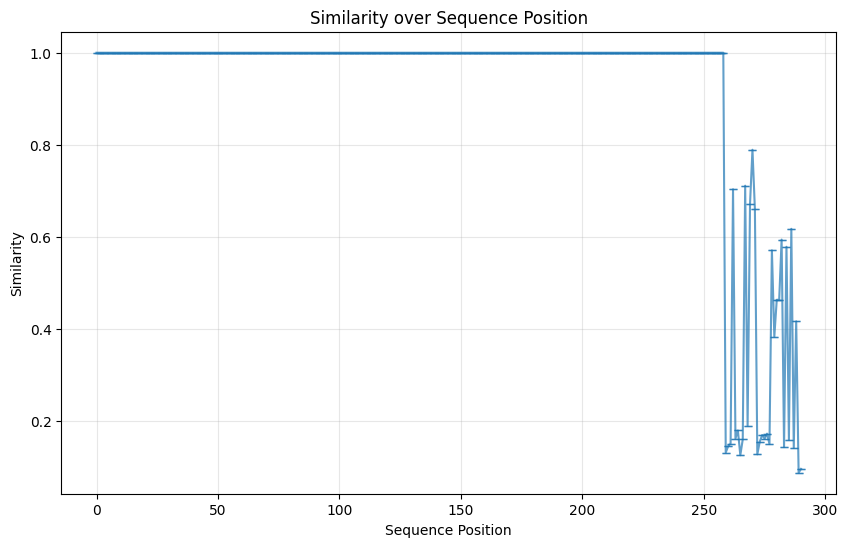

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


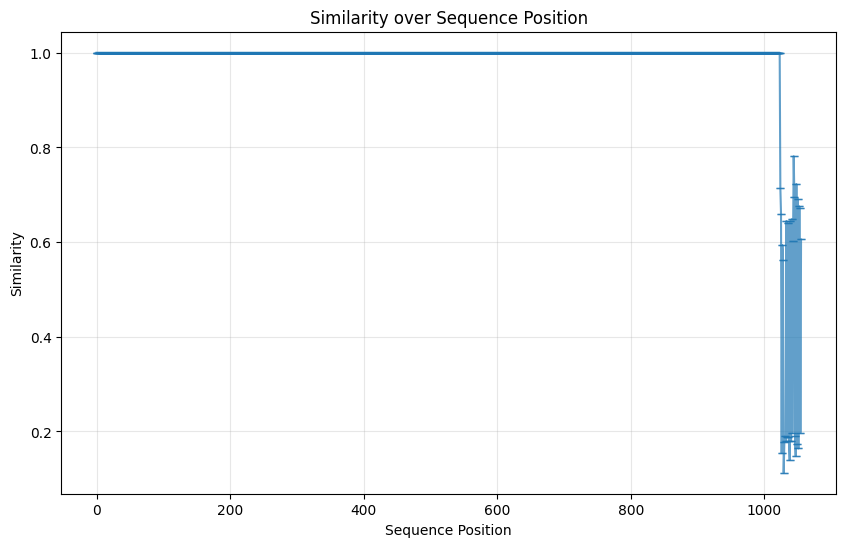

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


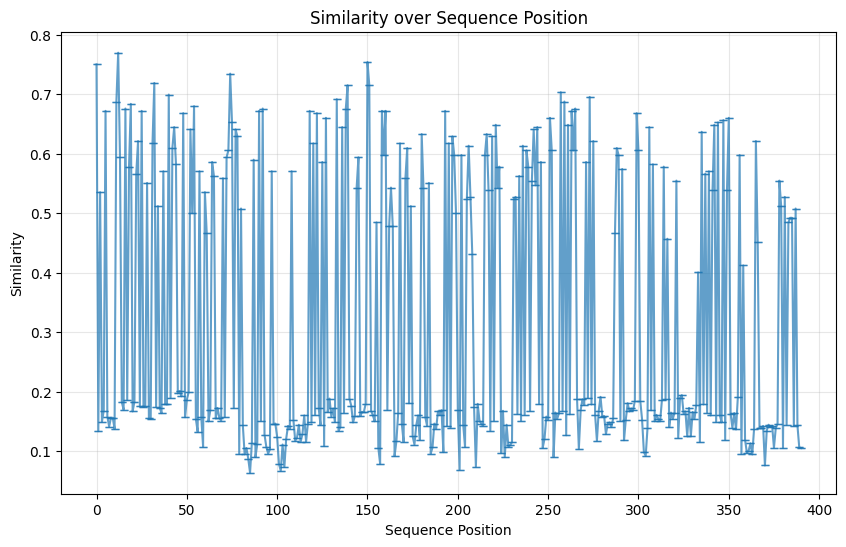

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


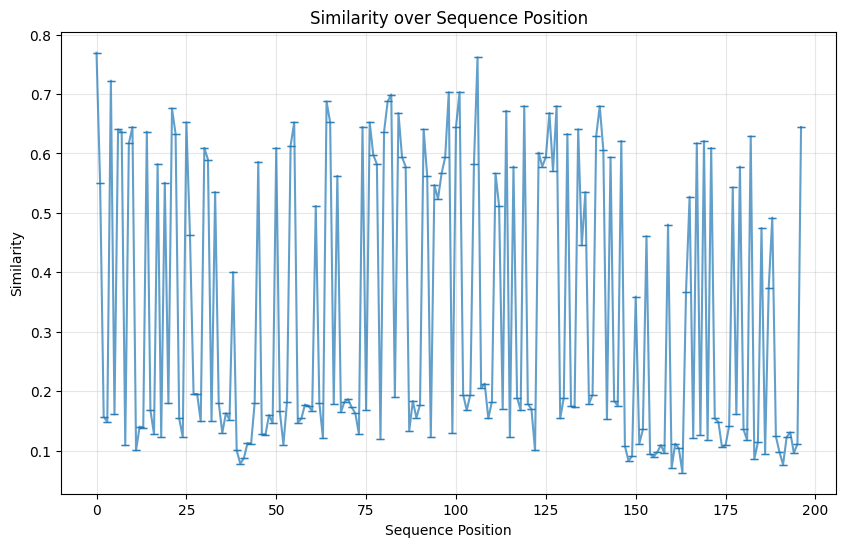

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


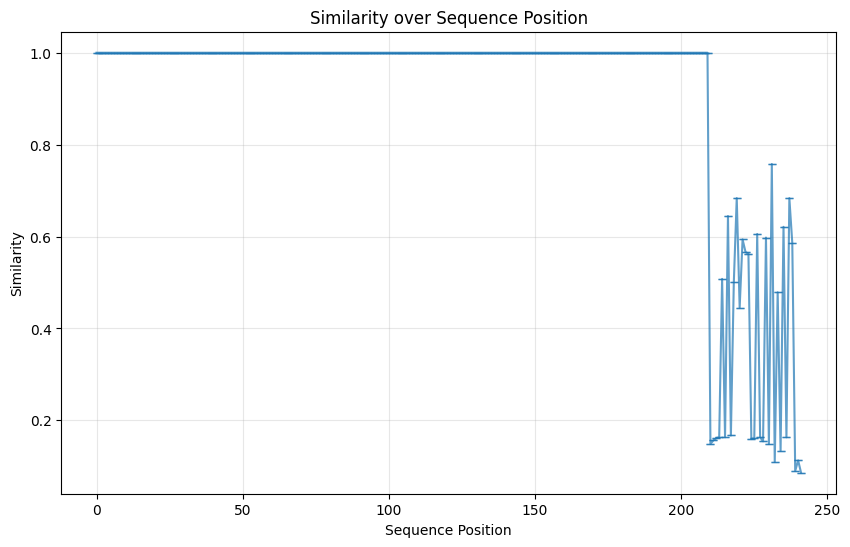

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


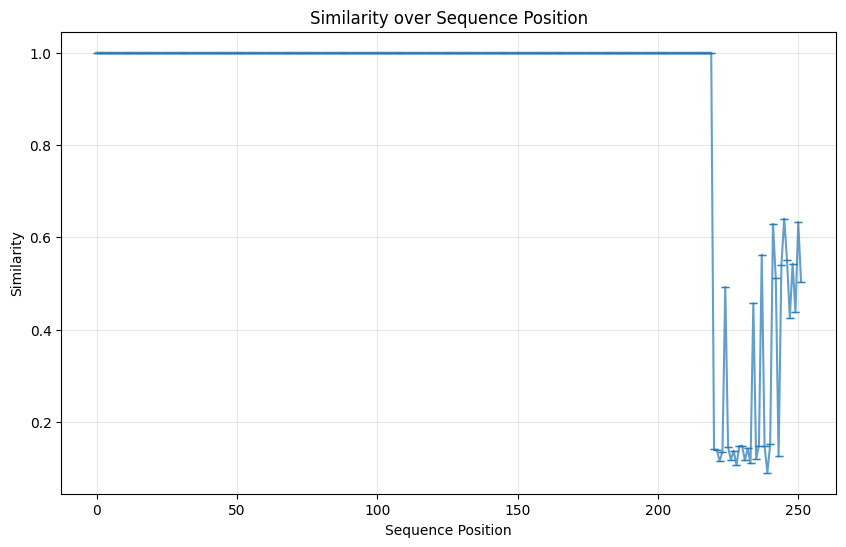

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


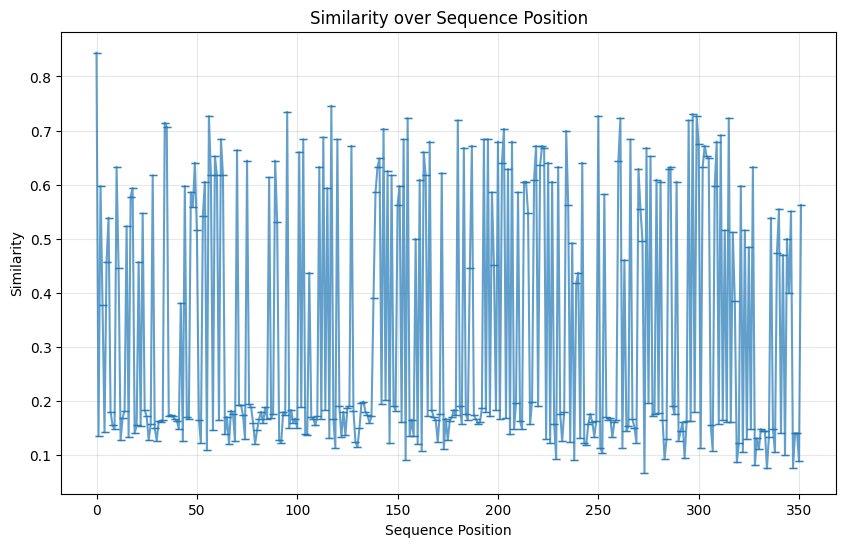

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


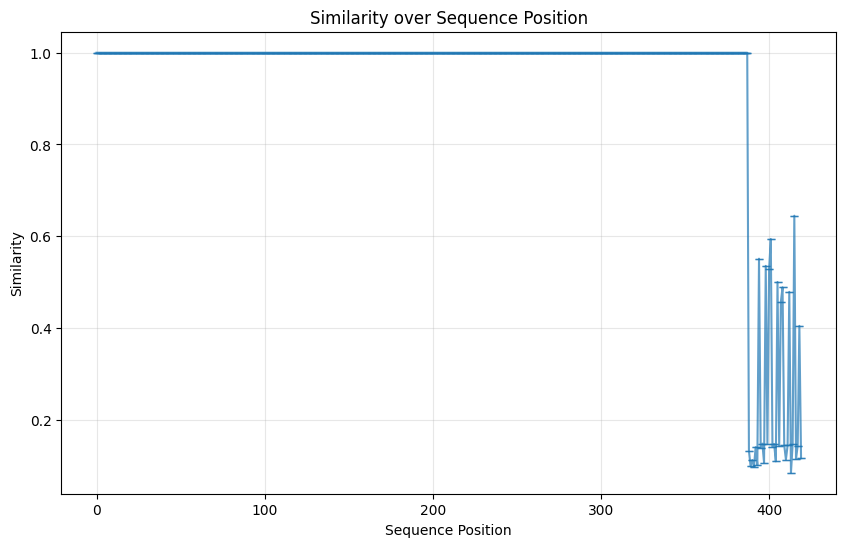

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


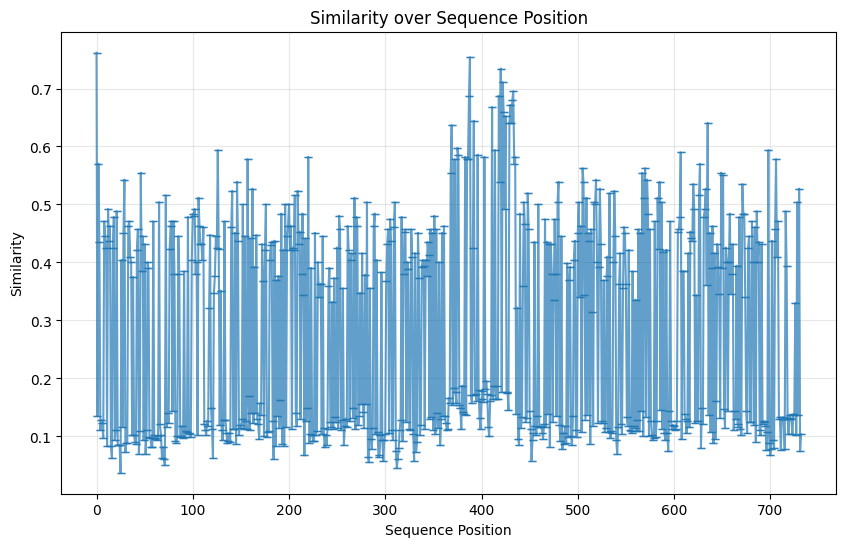

torch.Size([291])
torch.Size([1056])
torch.Size([391])
torch.Size([197])
torch.Size([242])
torch.Size([252])
torch.Size([352])
torch.Size([420])
torch.Size([733])
torch.Size([736])


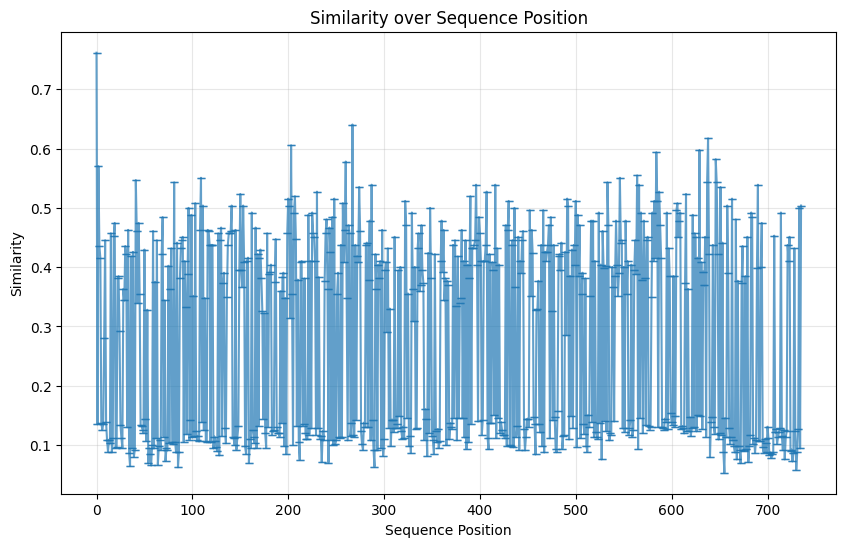

In [34]:
import torch
import matplotlib.pyplot as plt

def compute_sequence_similarities(prefill_acts_list, orig_acts_list, k=64):
    """
    Compute similarities for each sequence individually.
    
    Args:
        prefill_acts_list: list of tensors, each of shape (seq_len, hidden_dim)
        orig_acts_list: list of tensors, each of shape (seq_len, hidden_dim)
        k: number of top values to keep
    
    Returns:
        list of similarity tensors, one per sequence
    """
    sequence_similarities = []
    
    for prefill_seq, orig_seq in zip(prefill_acts_list, orig_acts_list):
        # Compress each sequence
        prefill_compressed = compress_activations(prefill_seq, k=k)
        orig_compressed = compress_activations(orig_seq, k=k)
        
        # Compute similarities for this sequence
        similarities = compute_euclidean_similarity_batch(prefill_compressed, orig_compressed)
        sequence_similarities.append(similarities)
    
    return sequence_similarities


def compute_position_statistics(sequence_similarities):
    """
    Compute statistics over sequence positions.
    
    Args:
        sequence_similarities: list of similarity tensors
    
    Returns:
        dict with position-wise statistics
    """
    # Find max sequence length
    max_len = max(sim.shape[0] for sim in sequence_similarities)
    
    # Collect similarities by position
    position_sims = [[] for _ in range(max_len)]
    
    for sim_seq in sequence_similarities:
        for pos, sim_val in enumerate(sim_seq):
            position_sims[pos].append(sim_val.item())
    
    # Compute statistics
    stats = {
        'mean': [],
        'std': [],
        'min': [],
        'max': [],
        'count': []
    }
    
    for pos_values in position_sims:
        if pos_values:
            pos_tensor = torch.tensor(pos_values)
            stats['mean'].append(pos_tensor.mean().item())
            stats['std'].append(pos_tensor.std().item() if len(pos_values) > 1 else 0)
            stats['min'].append(pos_tensor.min().item())
            stats['max'].append(pos_tensor.max().item())
            stats['count'].append(len(pos_values))
        else:
            # No data for this position
            stats['mean'].append(None)
            stats['std'].append(None)
            stats['min'].append(None)
            stats['max'].append(None)
            stats['count'].append(0)
    
    return stats


def plot_similarity_over_position(stats, title="Similarity over Sequence Position"):
    """
    Plot how similarity changes over sequence positions.
    """
    positions = range(len(stats['mean']))
    
    # Filter out None values
    valid_positions = [i for i, m in enumerate(stats['mean']) if m is not None]
    means = [stats['mean'][i] for i in valid_positions]
    stds = [stats['std'][i] for i in valid_positions]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(valid_positions, means, yerr=stds, alpha=0.7, capsize=3)
    plt.xlabel('Sequence Position')
    plt.ylabel('Similarity')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Also plot sample sizes
    # plt.figure(figsize=(10, 4))
    # plt.bar(positions, stats['count'], alpha=0.7)
    # plt.xlabel('Sequence Position')
    # plt.ylabel('Number of Sequences')
    # plt.title('Sample Size per Position')
    # plt.grid(True, alpha=0.3)
    # plt.show()


def get_sequence_summary_stats(sequence_similarities):
    """
    Get summary statistics for each sequence.
    
    Returns:
        tensor of shape (num_sequences, 4) with [mean, std, min, max] per sequence
    """
    summary_stats = []
    
    for sim_seq in sequence_similarities:
        stats = torch.stack([
            sim_seq.mean(),
            sim_seq.std() if len(sim_seq) > 1 else torch.tensor(0.0),
            sim_seq.min(),
            sim_seq.max()
        ])
        summary_stats.append(stats)
    
    return torch.stack(summary_stats)


# Usage example:
# Compute similarities for each sequence

for idx in range(len(prefill_activations)):
    sequence_sims = compute_sequence_similarities(prefill_activations, orig_activations, k=64)[idx:idx+1]

    # Get position-wise statistics
    position_stats = compute_position_statistics(sequence_sims)

    # Plot how similarity changes over positions
    plot_similarity_over_position(position_stats)

    # Get per-sequence summary stats (for classification)
    # seq_stats = get_sequence_summary_stats(sequence_sims)
    # print(f"Shape of sequence stats: {seq_stats.shape}")  # (num_sequences, 4)
    # print(f"Average sequence similarity: {seq_stats[:, 0].mean():.4f}")

    # # Look at first few sequences
    # for i in range(min(5, len(sequence_sims))):
    #     print(f"\nSequence {i}:")
    #     print(f"  Length: {len(sequence_sims[i])}")
    #     print(f"  Mean sim: {seq_stats[i, 0]:.4f}")
    #     print(f"  Std sim: {seq_stats[i, 1]:.4f}")
    #     print(f"  Min/Max: {seq_stats[i, 2]:.4f} / {seq_stats[i, 3]:.4f}")